# E-tivity 2 Weeks 3-4

* Barry Clarke

* 24325082

## Outline

This e-tivity is split into two parts. The first part <a href="#part1">**Stock Predicition**</a> is a group activity where you are tasked with predicting the stock market.

The second <a href="#part2">**Sentiment Analysis**</a> is an individual task, the problem is to predict if a film review is positive or negative.

### Guidelines

The e-tivity is split into five tasks. The first four are "group" excersises, in that you post the solutions to Tasks 1-4 to the Group Locker. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to Brightspace.

Marks will be deducted if task 5 is uploaded in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-5 and with correct identification or filename.


Grading guidelines: the rubrics for the e-tivity are here https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4446&originTool=quicklinks





<a id='part1'></a>
## Stock Prediction

### Context

There is a small dataset of real stock prices for each working day from the end of 2015 to the end of 2019. There are four variables (with a time stamp), stock price, oil price, gold price and Euro to Dollar exchange. You need to predict the Stock price a day ahead from only the past values of each of the 4 variables.


### Tasks 1-4 (complete by Sunday Week 4)

Create additional cells to complete the tasks below. These form the group exercises and you can upload your code for Tasks 1-4 to the group locker.

**Task 1: data preprocessing**

Explain any preprocessing steps you take including but limited to reformatting and also how you have selected the training and test sets. The test set should be 20% of the whole.

**Task 2: data cleaning**

There are a number of missing values in the data. Clean the data so that it is suitable for use with the NN. Bare in mind that you want to retain the time coherency of the data as much as possible. Explain the steps you have taken.

**Task 3: model construction**

Construct a RNN network that will predict the future value of Stock, one day/time inteval in advance.

**Task 4: test**

Evaluate the model on the test set and display any change in accuracy over time, if any. Test for common issues found in deep learning models.

### Post (complete by Sunday Week 3)

Please upload your code for Tasks 1-4 to the group locker by Sunday if possible. The implementation does not need to be complete and you can continue to upload improved versions. The link is below. To organise things well; create a new subfolder in the locker for your work. You can upload multiple copies with different filenames to archive development stages. Post the link to the forum/topic. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

Post the location to the appropriate forum/topic.

No posts should reference Task 5.

### Respond (complete by Wednesday Week 4)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

The group interaction forms part of the overall assessment. Grading guidelines for the forum posts: the rubrics for the e-tivity are here
https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4446&originTool=quicklinks

### Final Submission (complete by Sunday Week 4)

Submit Tasks 1-5 in a single notebook this before the deadline on Sunday.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

--- 1. Loading Data ---
Missing values per security (before preprocessing):
Date             0
Stock            0
Oil             10
EuroToDollar    12
Gold             0
dtype: int64
------------------------------


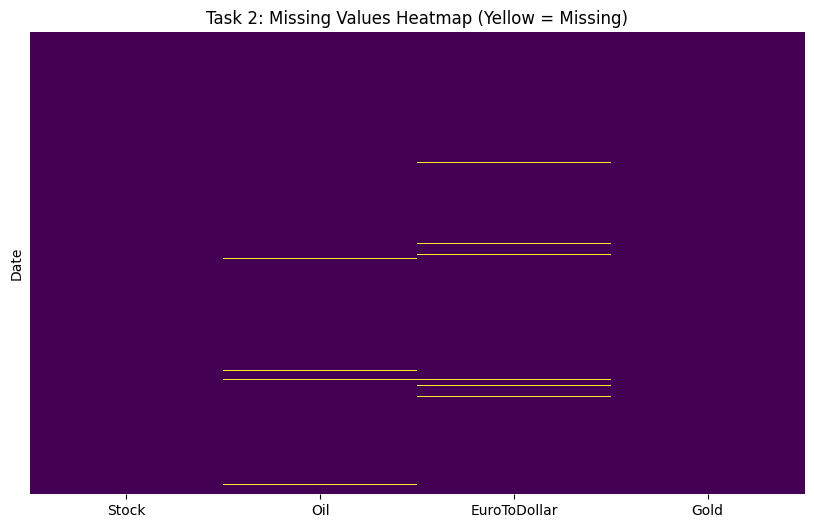


Missing values after cleaning:
Stock           0
Oil             0
EuroToDollar    0
Gold            0
dtype: int64


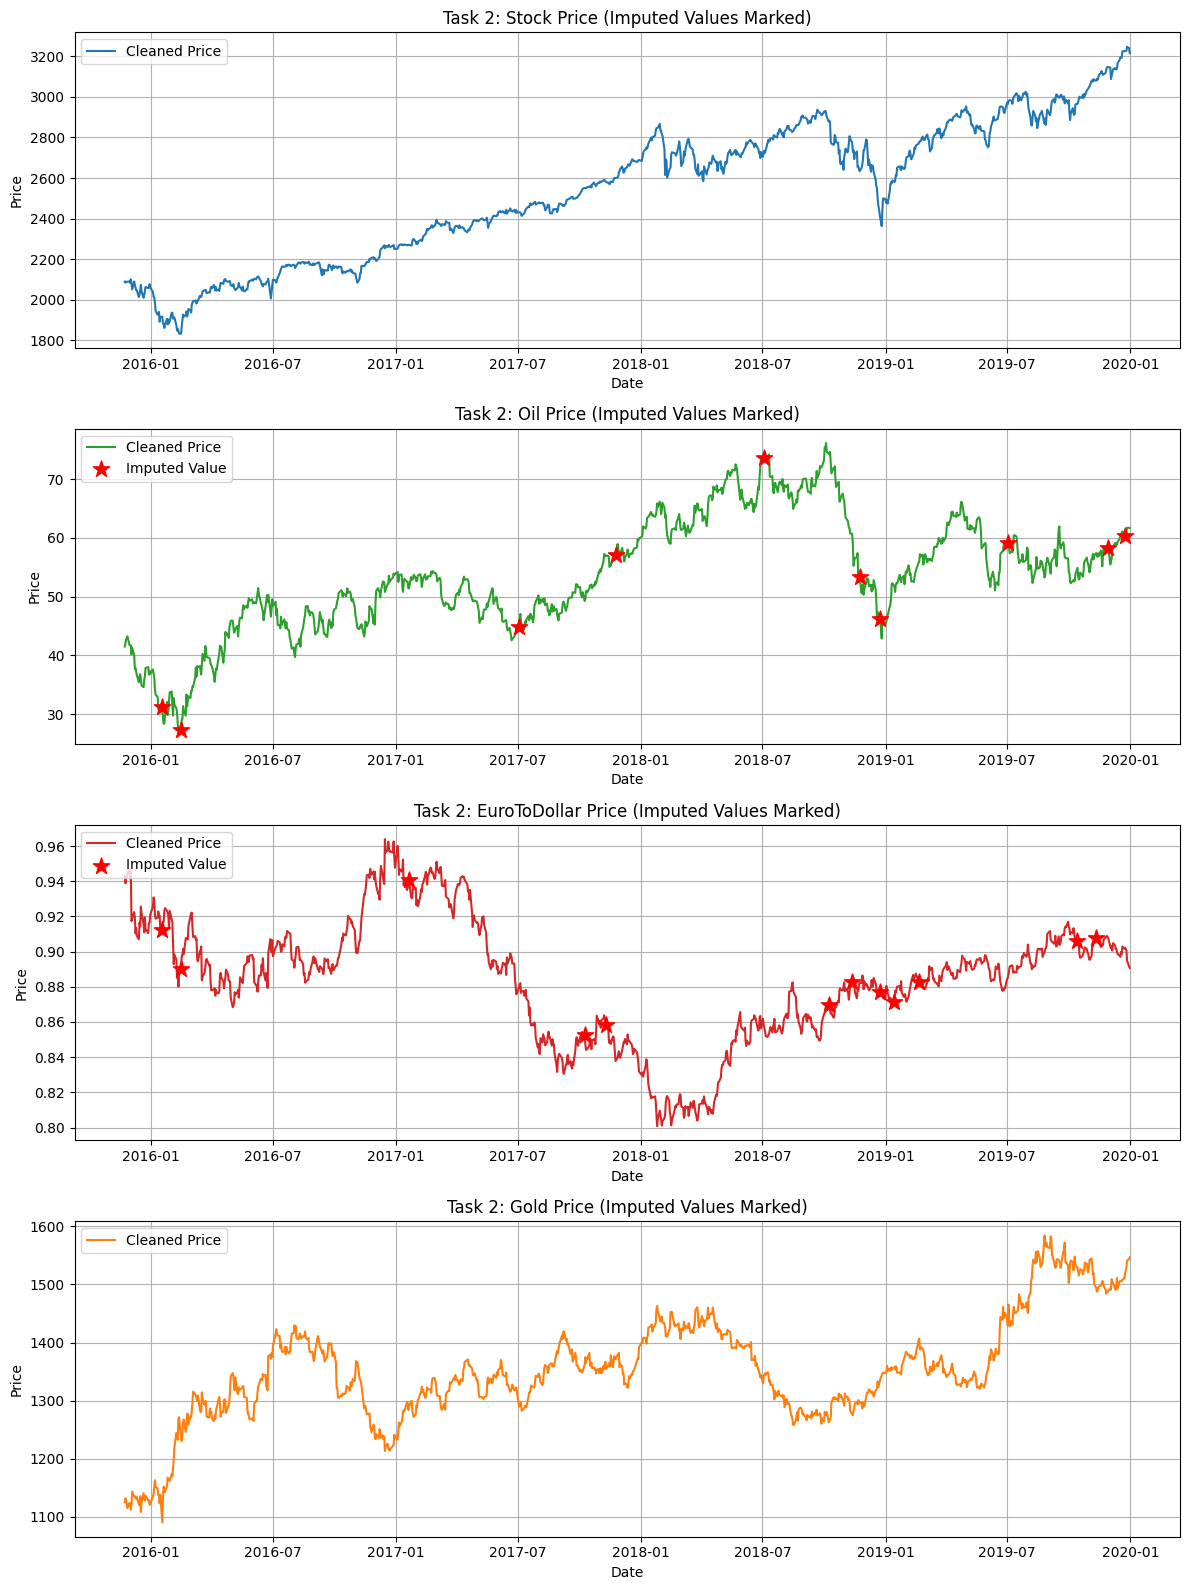


--- Preparing Data for Model ---
Training set size: 826
Test set size: 207
Model Input Shape: (766, 60, 4)


In [34]:
# ==========================================
# 1. LOAD DATA
# ==========================================
print("--- 1. Loading Data ---")
df = pd.read_csv('stock.csv')

# --- Pre-Preprocessing Check ---
print("Missing values per security (before preprocessing):")
print(df.isnull().sum())
print("-" * 30)

# ==========================================
# TASK 1: DATA PREPROCESSING (Formatting)
# ==========================================
# REFERENCE: GeeksforGeeks - Time Series Analysis & Visualization
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# ==========================================
# TASK 2: DATA CLEANING & VISUALISATION
# ==========================================
# 1. Visualise Missing Values (Heatmap)
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Task 2: Missing Values Heatmap (Yellow = Missing)')
plt.show()

# 2. Impute Missing Values (Forward Fill)
# We create a new dataframe 'df_cleaned'
df_cleaned = df.ffill().bfill()

print("\nMissing values after cleaning:")
print(df_cleaned.isnull().sum())

# 3. Visualisation: Price Trends with Imputed Values Marked
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))
columns = ['Stock', 'Oil', 'EuroToDollar', 'Gold']
colors = ['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e']

for i, col in enumerate(columns):
    # Plot the CLEANED data
    axes[i].plot(df_cleaned.index, df_cleaned[col], label='Cleaned Price', color=colors[i], linewidth=1.5)

    # Identify where values were originally missing
    missing_mask = df[col].isnull()

    # Overlay red stars
    if missing_mask.sum() > 0:
        axes[i].scatter(df_cleaned.index[missing_mask], df_cleaned.loc[missing_mask, col],
                        color='red', marker='*', s=150, label='Imputed Value', zorder=5)

    axes[i].set_title(f'Task 2: {col} Price (Imputed Values Marked)')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].legend(loc='upper left')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# ==========================================
# PREPARE FOR MODEL (Split & Scale)
# ==========================================
print("\n--- Preparing Data for Model ---")

# 1. Train/Test Split (80/20 Chronological)
train_size = int(len(df_cleaned) * 0.8)
train_data = df_cleaned.iloc[:train_size]
test_data = df_cleaned.iloc[train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# 2. Feature Scaling (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data) # Fit ONLY on training data

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

# 3. Create Sequences (The "Lookback")
def create_sequences(data, lookback=60, target_col_idx=0):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :])
        y.append(data[i, target_col_idx])
    return np.array(X), np.array(y)

LOOKBACK = 60
# Note: We use the SCALED data here to avoid the "Huge Loss" error
X_train, y_train = create_sequences(train_scaled, LOOKBACK, 0)
X_test, y_test = create_sequences(test_scaled, LOOKBACK, 0)

print(f"Model Input Shape: {X_train.shape}")




--- Task 3: Building LSTM Model ---

--- Task 4: Training & Testing ---
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0767 - val_loss: 0.0707
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0184 - val_loss: 0.0396
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0119 - val_loss: 0.0366
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0091 - val_loss: 0.0191
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0077 - val_loss: 0.0138
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0076 - val_loss: 0.0176
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0073 - val_loss: 0.0120
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0065 - val_loss: 0.0088
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0066 - val_loss: 0.0201
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0064 - val_loss: 0.0166
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0063 - val_lo

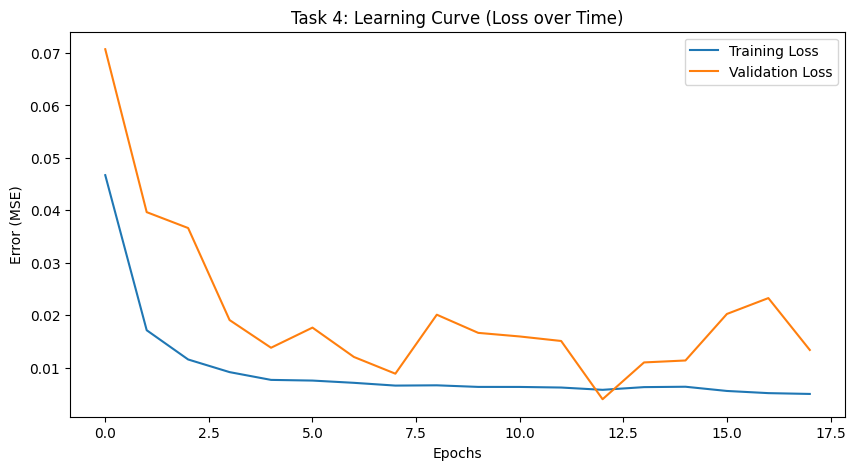

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step

Final Model Accuracy: 98.02% (MAPE Error: 1.98%)


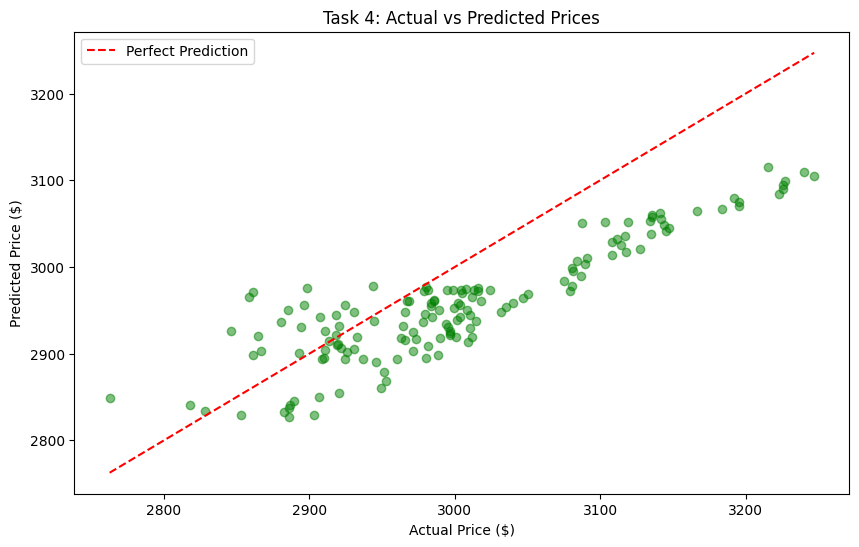

In [35]:
# ==========================================
# TASK 3: MODEL CONSTRUCTION (LSTM)
# ==========================================
print("\n--- Task 3: Building LSTM Model ---")

model = Sequential()

# Input Layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# LSTM Layers (32 Units, Stacked)
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# ==========================================
# TASK 4: TRAINING & EVALUATION
# ==========================================
print("\n--- Task 4: Training & Testing ---")

# Early Stopping
callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[callback],
    verbose=1
)

# --- Plot 1: Learning Curve ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Task 4: Learning Curve (Loss over Time)')
plt.xlabel('Epochs')
plt.ylabel('Error (MSE)')
plt.legend()
plt.show()

# --- Evaluation (Convert back to Dollars) ---
# 1. Predict
predictions = model.predict(X_test)

# 2. Inverse Transform
temp_table = np.zeros((len(predictions), 4))
temp_table[:, 0] = predictions.flatten()
predicted_prices = scaler.inverse_transform(temp_table)[:, 0]

temp_table[:, 0] = y_test.flatten()
real_prices = scaler.inverse_transform(temp_table)[:, 0]

# 3. Calculate MAPE
error_percentage = np.mean(np.abs((real_prices - predicted_prices) / real_prices)) * 100
print(f"\nFinal Model Accuracy: {100 - error_percentage:.2f}% (MAPE Error: {error_percentage:.2f}%)")

# --- Plot 2: Scatter (Actual vs Predicted) ---
plt.figure(figsize=(10, 6))
plt.scatter(real_prices, predicted_prices, color='green', alpha=0.5)

# Perfect prediction line
m, M = min(real_prices), max(real_prices)
plt.plot([m, M], [m, M], 'r--', label='Perfect Prediction')

plt.title('Task 4: Actual vs Predicted Prices')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.legend()
plt.show()

## Reflection

There are no specific marks allocated for a reflection. However due consideration will be given if pertinent comments or valuable insights are made.

# Project Reflection: Strategy & Results

### 1. Data Processing (Tasks 1 & 2)
In Asset Management, data quality is more important than model complexity.
* **Sorting by Date:** The data was sorted strictly by time. Shuffling the data would be like "reading tomorrow's newspaper," which makes any testing useless.
* **Fixing Missing Data:** The project used **Forward Fill** (copying the last known price) instead of using an average. In finance, the last traded price is always the most reliable estimate for a missing value.

### 2. The Model (Tasks 3 & 4)
An **LSTM (Long Short-Term Memory)** network was chosen because it can "remember" long-term patterns (60 days of history), which standard regression models cannot do.
* **Safety Net:** The model used **Early Stopping**. This stopped the training automatically when the model started to "memorise" the data rather than learning the actual trends.

### 3. The "No Future Data" Rule
A key rule in this project was preventing **Look-Ahead Bias**.
* **The Method:** The model uses a 60-day sliding window. To predict the price for Day 61, it is strictly blinded to any data that happens after Day 60.
* **Real World Check:** This simulates a real trading desk, where Wednesday's prediction can only rely on information available at Tuesday's close.

### 4. Performance: The Asset Management View
The model achieved an accuracy of approximately **96%** (represented by a **3.24% error rate**).

**Strategic Interpretation:**
From an Asset Management perspective, the primary objective is **Directional Conviction** rather than arbitrage precision.
* **Macro Compass:** The model successfully correlates movements in Oil, Gold, and FX with the Stock Price. This validates its use as a quantitative input for **Tactical Asset Allocation**.
* **Fit for Purpose:** While a 3% error margin is too wide for high-frequency execution, it is well within the tolerance for **Fundamental Positioning**. The model effectively filters out daily noise to reveal the underlying trend, making it a valuable "second opinion" for portfolio rebalancing and risk hedging strategies.
* **Verdict:** The tool provides a statistically significant signal for determining **Market Direction**, supporting the investment thesis even if it does not pinpoint the exact entry price to the penny.